## Tutorial - Seq2Seq model for Neural Machine Translation
This tutorial is adapted from [_NLP From Scratch: Translation with a Sequence to Sequence Network and Attention_](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) tutorial from Pytoch documentations.

In this tutorial you will learn how to one language to another using neural network. Here, we treanslate English to French as example.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> vous etes trop maigre .
= you re too skinny .
< you re all alone .

```

In [10]:
#Generic imports and OS settings
import os
import csv
import glob
import matplotlib
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
## Requirements
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from tqdm import trange
import torch
import nltk 

#Custom imports and device settings
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate import meteor
from nltk.corpus import stopwords

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Part1 - Seq2Seq model

Transforming one sequence to another is possible by the simple but powerful idea of the [sequence to sequence network](https://arxiv.org/abs/1409.3215), in which two recurrent neural networks work. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

![seq2seq](https://pytorch.org/tutorials/_images/seq2seq.png)

#### Loading data files

The data used in this tutorial contains thousands of English to French translation pairs.

This question on Open Data Stack Exchange pointed me to the open translation site https://tatoeba.org/ which has downloads available at https://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: https://www.manythings.org/anki/

The English to French pairs can be found at data/eng-fra.txt. It is a tab separated list of translation pairs.
```
I am cold.    J'ai froid.
```

We will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). There are many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

![vocab](https://pytorch.org/tutorials/_images/word-encoding.png)

We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count which will be used to replace rare words later.

In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def stoi(self, word):
        return self.word2index[word]
    
    def itos(self, ndx):
        return self.index2word[ndx]

All files are in Unicode, to simplify, we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# RECIPE DATA PROCESSING

Pipeline is: 
1. process raw text extracts recipe pairs from the raw text folders by calling text-to-recipe
2. recipes are cleaned up with data normalisation and preprocessing
3. write-tsv writes the tsv objects with the recipe list

these TSV files are our new data

4. extract pairs pulls the data from the tsv files
5. the pairs are passed into build-language as well as into their own object
6. pairs and both languages are returned

In [15]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
measurements = {"c", "tsp", "tbsp", "qt", "cn", "lb", "ts", "ea", "lg", "tb"}
stop_words.update(measurements)


def trim_stopwords(text):
    output = " ".join([word for word in str(text).split() if word not in stop_words])
    output = output.lower()
    return output

def recipe_cleanup(all_recipes):
    outputs = []
    for recipe in all_recipes:
        clean_ing = trim_stopwords(recipe[0])
        clean_step = trim_stopwords(recipe[1])
        outputs.append((clean_ing, clean_step))
    return outputs

    #     - lower (10 mins)
    # - dissolve contractions (30 mins)
    # - remove stopwords (20 mins)

# test_recipe = trim_stopwords("Ours is the Question of Glory")
# print(test_recipe)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def text_to_recipe_processing(line):
    title = re.findall(r'Title: (.*)', line)
    ingredients = re.findall(r'ingredients: (.*)', line)
    steps = re.findall(r'ingredients: .*\n([\s\S]*)', line)
    try:
        title = title[0]
        title = re.sub(r'[^a-zA-Z ]', '', title) #remove non-alpha or underscore characters
        title = re.sub(r'\s+', ' ', title) #remove excess spaces
        ingredients = ingredients[0].replace('''\t''', " ") #replace tab with space for better formatting
        ingredients = re.sub(r'[^a-zA-Z ]', '', ingredients)
        ingredients = re.sub(r'\s+', ' ', ingredients)
        steps = steps[0].replace('''\n''', " ") #replace newline in steps with space
        steps = re.sub(r'[^a-zA-Z ]', '', steps)
        steps = re.sub(r'\s+', ' ', steps)
    except:
        return None
    return (str(title + " " + ingredients), str(steps))

def process_rawtext(path):
    print("Processing text data from {}".format(path))
    recipes = []
    files = glob.glob(path + "/*.txt")
    for file in files:
        lines = open(file, encoding='utf-8').read().strip().split("END RECIPE")
        for l in lines:
            recipe = text_to_recipe_processing(l)
            if recipe is not None:
                recipes.append(recipe)
    return recipes

def write_to_tsv(destination, recipe_list):
    with open(destination, 'w',  newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        for recipe in recipe_list:
            writer.writerow(recipe)

def build_language(data_paths):
    all_ingredients = []
    all_recipes = []
    for path in data_paths: #manual path list:
        recipes = extract_pairs(path)
        for r in recipes:
            all_ingredients.append(r[0])
            all_recipes.append(r[1])
    ingredient_lang = Lang("ingredients")
    recipe_lang = Lang("recipes")
    for ing in all_ingredients:
        ingredient_lang.addSentence(ing)
    for rec in all_recipes:
        recipe_lang.addSentence(rec)
    return ingredient_lang, recipe_lang

# def extract_pairs(path):
#     all_recipes = []
#     file = open(path, 'r')
#     lines = file.readlines()
#     for l in lines:
#         items = [normalizeString(s) for s in l.split("""\t""")]
#         all_recipes.append(items)
#     all_recipes = filterPairs(all_recipes)
#     return all_recipes


In [16]:
### Recipes with stopwords included
# train_recipes = process_rawtext("Cooking_Dataset/train")
# write_to_tsv("Dataset/train.tsv", train_recipes)
# test_recipes = process_rawtext("Cooking_Dataset/test")
# write_to_tsv("Dataset/test.tsv", test_recipes)
# dev_recipes = process_rawtext("Cooking_Dataset/dev")
# write_to_tsv("Dataset/dev.tsv", dev_recipes)

###Recipes without stopwords
train_recipes = process_rawtext("Cooking_Dataset/train")
cleaned_train = recipe_cleanup(train_recipes)
write_to_tsv("Clean_Data/train.tsv", cleaned_train)
dev_recipes = process_rawtext("Cooking_Dataset/dev")
cleaned_dev = recipe_cleanup(dev_recipes)
write_to_tsv("Clean_Data/dev.tsv", cleaned_dev)
test_recipes = process_rawtext("Cooking_Dataset/test")
cleaned_test = recipe_cleanup(test_recipes)
write_to_tsv("Clean_Data/test.tsv", cleaned_test)

Processing text data from Cooking_Dataset/test


To read the data file we will split the file into lines, and then split lines into pairs. The used files contain English → Other Language, so I added the `reverse` flag to reverse the pairs, in case that you want to translate from Other Language → English .

In [2]:
# def readLangs(lang1, lang2, reverse=False):
#     print("Reading lines...")

#     # Read the file and split into lines
#     file_name = 'data/%s-%s.txt' % (lang1, lang2)
#     lines = open(file_name, encoding='utf-8').\
#         read().strip().split('\n')

#     # Split every line into pairs and normalize
#     pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

#     # Reverse pairs, make Lang instances
#     if reverse:
#         pairs = [list(reversed(p)) for p in pairs]
#         input_lang = Lang(lang2)
#         output_lang = Lang(lang1)
#     else:
#         input_lang = Lang(lang1)
#         output_lang = Lang(lang2)

#     return input_lang, output_lang, pairs


Pairs can be later extracted from the .tsv files and returned as recipes, after being filtered for passing max length and the strings normalised (just in case any stray data makes it through the cleanup phase)

In [1]:
MAX_LENGTH = 150 

# eng_prefixes = (
#     "i am ", "i m ",
#     "he is", "he s ",
#     "she is", "she s ",
#     "you are", "you re ",
#     "we are", "we re ",
#     "they are", "they re "
# )

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def extract_pairs(path):
    all_recipes = []
    file = open(path, 'r')
    lines = file.readlines()
    for l in lines:
        items = [normalizeString(s) for s in l.split("""\t""")]
        all_recipes.append(items)
    all_recipes = filterPairs(all_recipes)
    return all_recipes

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs


In [8]:
# def prepareData(lang1, lang2, reverse=False):
#     input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
#     print("Read %s sentence pairs" % len(pairs))
#     pairs = filterPairs(pairs)
#     print("Trimmed to %s sentence pairs" % len(pairs))
#     print("Counting words...")
#     for pair in pairs:
#         input_lang.addSentence(pair[0])
#         output_lang.addSentence(pair[1])
#     print("Counted words:")
#     print(input_lang.name, input_lang.n_words)
#     print(output_lang.name, output_lang.n_words)
#     return input_lang, output_lang, pairs


# input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
# print(random.choice(pairs))
dataset_path = ["Dataset/train.tsv", "Dataset/dev.tsv", "Dataset/test.tsv"]
input_lang, output_lang = build_language(dataset_path)
pairs = extract_pairs("Dataset/train.tsv")

### MODEL DEFINITION - MODEL ONE
A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network, or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

![seq2seq](https://pytorch.org/tutorials/_images/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne/pas” construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

#### The Encoder
The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

![encoder](https://pytorch.org/tutorials/_images/encoder-network.png)

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### The Decoder
The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

**Simple Decoder**

In the simplest seq2seq decoder, we only use the last output of the encoder. This last output is sometimes called the context vector as it encodes context for the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).
![decoder](https://pytorch.org/tutorials/_images/decoder-network.png)

In [48]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        # output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


#### Preparing Training data
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### Training the Model
To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the `<SOS>` token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster [but when the trained network is exploited, it may exhibit instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn `teacher_forcing_ratio` up to use more of it.

In [14]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder_hidden

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(
            input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = decoder_hidden

    use_teacher_forcing = True 
    # if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [22]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


### Plotting Helper Fn

In [11]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
    
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.



  1%|▏         | 500/35000 [02:13<1:34:01,  6.12it/s]

2m 17s (- 158m 37s) (500 1%) 7.2398


  3%|▎         | 1000/35000 [04:28<2:51:25,  3.31it/s]

4m 32s (- 154m 16s) (1000 2%) 6.1587


  4%|▍         | 1500/35000 [06:37<2:01:40,  4.59it/s]

6m 41s (- 149m 29s) (1500 4%) 5.6458


  6%|▌         | 2000/35000 [08:49<3:29:05,  2.63it/s]

8m 54s (- 146m 53s) (2000 5%) 5.4334


  7%|▋         | 2500/35000 [11:05<2:46:35,  3.25it/s]

11m 9s (- 145m 3s) (2500 7%) 5.1940


  9%|▊         | 3000/35000 [13:14<1:45:16,  5.07it/s]

13m 18s (- 141m 56s) (3000 8%) 5.0791


 10%|█         | 3500/35000 [15:24<2:16:27,  3.85it/s]

15m 29s (- 139m 21s) (3500 10%) 5.0107


 11%|█▏        | 4000/35000 [17:39<2:31:31,  3.41it/s]

17m 43s (- 137m 20s) (4000 11%) 4.9220


 13%|█▎        | 4500/35000 [19:53<2:25:11,  3.50it/s]

19m 57s (- 135m 18s) (4500 12%) 4.8118


 14%|█▍        | 5000/35000 [22:06<1:59:51,  4.17it/s]

22m 10s (- 133m 3s) (5000 14%) 4.7537


 16%|█▌        | 5500/35000 [24:17<2:19:01,  3.54it/s]

24m 21s (- 130m 40s) (5500 15%) 4.6145


 17%|█▋        | 6000/35000 [26:26<2:27:44,  3.27it/s]

26m 30s (- 128m 7s) (6000 17%) 4.5934


 19%|█▊        | 6500/35000 [28:35<1:46:22,  4.47it/s]

28m 40s (- 125m 42s) (6500 18%) 4.6037


 20%|██        | 7000/35000 [30:47<1:52:40,  4.14it/s]

30m 52s (- 123m 28s) (7000 20%) 4.4998


 21%|██▏       | 7500/35000 [32:52<1:45:58,  4.33it/s]

32m 56s (- 120m 46s) (7500 21%) 4.4894


 23%|██▎       | 8000/35000 [35:10<2:03:48,  3.63it/s]

35m 14s (- 118m 55s) (8000 22%) 4.4774


 24%|██▍       | 8500/35000 [37:22<1:19:23,  5.56it/s]

37m 26s (- 116m 45s) (8500 24%) 4.4524


 26%|██▌       | 9000/35000 [39:35<2:08:38,  3.37it/s]

39m 40s (- 114m 35s) (9000 25%) 4.4737


 27%|██▋       | 9500/35000 [41:49<1:33:09,  4.56it/s]

41m 53s (- 112m 27s) (9500 27%) 4.4188


 29%|██▊       | 10000/35000 [43:59<1:51:52,  3.72it/s]

44m 3s (- 110m 8s) (10000 28%) 4.3999


 30%|███       | 10500/35000 [46:15<1:41:23,  4.03it/s]

46m 19s (- 108m 4s) (10500 30%) 4.2460


 31%|███▏      | 11000/35000 [48:27<1:53:47,  3.52it/s]

48m 31s (- 105m 52s) (11000 31%) 4.3119


 33%|███▎      | 11500/35000 [50:37<1:26:34,  4.52it/s]

50m 42s (- 103m 36s) (11500 32%) 4.3184


 34%|███▍      | 12000/35000 [52:50<1:37:35,  3.93it/s]

52m 55s (- 101m 25s) (12000 34%) 4.3145


 36%|███▌      | 12500/35000 [55:08<1:31:10,  4.11it/s]

55m 12s (- 99m 22s) (12500 35%) 4.2587


 37%|███▋      | 13001/35000 [57:15<1:42:32,  3.58it/s]

57m 19s (- 97m 0s) (13000 37%) 4.2724


 39%|███▊      | 13499/35000 [59:34<1:51:39,  3.21it/s]

59m 38s (- 94m 59s) (13500 38%) 4.2522


 40%|████      | 14001/35000 [1:01:49<1:30:21,  3.87it/s]

61m 53s (- 92m 49s) (14000 40%) 4.2176


 41%|████▏     | 14500/35000 [1:04:03<1:28:57,  3.84it/s]

64m 8s (- 90m 40s) (14500 41%) 4.1948


 43%|████▎     | 15000/35000 [1:06:15<1:20:15,  4.15it/s]

66m 20s (- 88m 26s) (15000 42%) 4.2339


 44%|████▍     | 15501/35000 [1:08:30<1:20:55,  4.02it/s]

68m 34s (- 86m 16s) (15500 44%) 4.1230


 46%|████▌     | 15999/35000 [1:10:45<1:30:29,  3.50it/s]

70m 50s (- 84m 7s) (16000 45%) 4.1785


 47%|████▋     | 16500/35000 [1:12:56<1:28:24,  3.49it/s]

73m 0s (- 81m 51s) (16500 47%) 4.0868


 49%|████▊     | 17000/35000 [1:15:09<1:51:25,  2.69it/s]

75m 14s (- 79m 39s) (17000 48%) 4.0970


 50%|█████     | 17500/35000 [1:17:21<1:05:38,  4.44it/s]

77m 25s (- 77m 25s) (17500 50%) 4.1044


 51%|█████▏    | 18000/35000 [1:19:33<1:27:56,  3.22it/s]

79m 37s (- 75m 11s) (18000 51%) 4.1177


 53%|█████▎    | 18500/35000 [1:21:47<1:17:32,  3.55it/s]

81m 51s (- 73m 0s) (18500 52%) 4.1626


 54%|█████▍    | 18999/35000 [1:23:59<54:31,  4.89it/s]  

84m 3s (- 70m 47s) (19000 54%) 4.1178


 56%|█████▌    | 19500/35000 [1:26:14<1:06:09,  3.90it/s]

86m 18s (- 68m 36s) (19500 55%) 4.1481


 57%|█████▋    | 20000/35000 [1:28:22<1:38:11,  2.55it/s]

88m 26s (- 66m 20s) (20000 57%) 4.0742


 59%|█████▊    | 20500/35000 [1:30:39<49:59,  4.83it/s]  

90m 44s (- 64m 10s) (20500 58%) 4.0935


 60%|██████    | 21001/35000 [1:32:52<46:32,  5.01it/s]  

92m 56s (- 61m 57s) (21000 60%) 4.0578


 61%|██████▏   | 21500/35000 [1:35:01<50:11,  4.48it/s]  

95m 6s (- 59m 42s) (21500 61%) 4.0505


 63%|██████▎   | 22000/35000 [1:37:12<49:45,  4.35it/s]  

97m 16s (- 57m 28s) (22000 62%) 3.9570


 64%|██████▍   | 22500/35000 [1:39:21<54:45,  3.80it/s]  

99m 26s (- 55m 14s) (22500 64%) 4.0023


 66%|██████▌   | 23000/35000 [1:41:38<31:33,  6.34it/s]  

101m 42s (- 53m 3s) (23000 65%) 4.0247


 67%|██████▋   | 23501/35000 [1:43:51<46:02,  4.16it/s]  

103m 55s (- 50m 51s) (23500 67%) 4.0202


 69%|██████▊   | 24000/35000 [1:46:04<53:59,  3.40it/s]  

106m 8s (- 48m 39s) (24000 68%) 3.9605


 70%|███████   | 24500/35000 [1:48:17<55:57,  3.13it/s]  

108m 21s (- 46m 26s) (24500 70%) 3.9416


 71%|███████▏  | 25001/35000 [1:50:28<41:14,  4.04it/s]  

110m 32s (- 44m 13s) (25000 71%) 4.0626


 73%|███████▎  | 25500/35000 [1:52:43<40:45,  3.88it/s]  

112m 47s (- 42m 1s) (25500 72%) 4.0071


 74%|███████▍  | 26000/35000 [1:54:50<42:24,  3.54it/s]  

114m 54s (- 39m 46s) (26000 74%) 4.0250


 76%|███████▌  | 26500/35000 [1:57:04<31:07,  4.55it/s]  

117m 8s (- 37m 34s) (26500 75%) 3.9779


 77%|███████▋  | 27000/35000 [1:59:12<43:56,  3.03it/s]  

119m 16s (- 35m 20s) (27000 77%) 3.9080


 79%|███████▊  | 27500/35000 [2:01:26<31:09,  4.01it/s]  

121m 30s (- 33m 8s) (27500 78%) 3.9462


 80%|████████  | 28000/35000 [2:03:34<21:58,  5.31it/s]

123m 39s (- 30m 54s) (28000 80%) 3.9858


 81%|████████▏ | 28500/35000 [2:05:48<34:26,  3.15it/s]

125m 52s (- 28m 42s) (28500 81%) 4.0148


 83%|████████▎ | 29001/35000 [2:07:57<18:07,  5.52it/s]

128m 1s (- 26m 29s) (29000 82%) 4.0000


 84%|████████▍ | 29500/35000 [2:10:12<30:10,  3.04it/s]

130m 16s (- 24m 17s) (29500 84%) 3.9550


 86%|████████▌ | 30000/35000 [2:12:26<31:24,  2.65it/s]

132m 30s (- 22m 5s) (30000 85%) 4.0163


 87%|████████▋ | 30501/35000 [2:14:43<15:42,  4.77it/s]

134m 47s (- 19m 53s) (30500 87%) 3.8329


 89%|████████▊ | 30999/35000 [2:16:52<24:40,  2.70it/s]

136m 57s (- 17m 40s) (31000 88%) 3.9165


 90%|█████████ | 31500/35000 [2:19:05<13:03,  4.47it/s]

139m 9s (- 15m 27s) (31500 90%) 3.8603


 91%|█████████▏| 32001/35000 [2:21:18<11:31,  4.33it/s]

141m 22s (- 13m 15s) (32000 91%) 3.8859


 93%|█████████▎| 32500/35000 [2:23:32<09:10,  4.55it/s]

143m 37s (- 11m 2s) (32500 92%) 3.8913


 94%|█████████▍| 33000/35000 [2:25:38<08:03,  4.14it/s]

145m 42s (- 8m 49s) (33000 94%) 3.8641


 96%|█████████▌| 33499/35000 [2:27:48<06:52,  3.64it/s]

147m 52s (- 6m 37s) (33500 95%) 3.9084


 97%|█████████▋| 34000/35000 [2:30:02<04:08,  4.02it/s]

150m 7s (- 4m 24s) (34000 97%) 3.9038


 99%|█████████▊| 34500/35000 [2:32:14<01:53,  4.40it/s]

152m 18s (- 2m 12s) (34500 98%) 3.9108


100%|██████████| 35000/35000 [2:34:30<00:00,  3.78it/s]

154m 34s (- 0m 0s) (35000 100%) 3.8118


<Figure size 640x480 with 0 Axes>

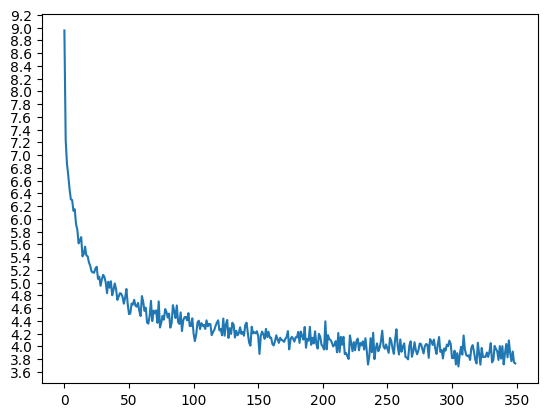

In [26]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    torch.save(encoder.state_dict(), "Checkpoints/Vanilla/encoder{}.pt".format(n_iters))
    torch.save(decoder.state_dict(), "Checkpoints/Vanilla/decoder{}.pt".format(n_iters))
    showPlot(plot_losses)

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
encoder1.to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)
decoder1.to(device)

trainIters(encoder1, decoder1, 35000, print_every=500)


#### Plotting results
Plotting is done with matplotlib, using the array of loss values `plot_losses` saved while training.

#### Evaluation
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder_hidden

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(
                input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = decoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [14]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### Training and Evaluating
With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. After about 40 minutes on a MacBook CPU we’ll get some reasonable results.

In [22]:
evaluateRandomly(encoder1, decoder1)

> sunshine cake md oranges pk lemon cake mix c vegetable oil eggs cool whip
= heat oven to f grease x x pan and set aside grate peel and squeeze juice from oranges add enough water to orange juice to measure cup beat cake mix lrb dry rrb tablespoon orange peel oil eggs and juice in large bowl for seconds on low speed then on medium speed for minutes pour into pan bake minutes or until cake springs back when lightly touched cool serve with cool whip whipped cream and if desired sprinkle with remaining orange rind
< preheat oven to f grease a large bowl combine flour and baking powder and salt in a large bowl combine flour and baking powder and mix well pour into pan and bake at f for minutes or until golden brown cool on wire rack <EOS>

> cous cous lamb lb lean lamb cut in chunks sm butternut squash peeled arlic cloves peeled seeded cut in chunks piece of fresh ginger cut sm egg plant cut in chunk into the same size as the carrots peeled cut in garlic chunks ts cummin ripe tomato cut i

## MODEL TWO - ATTENTION SEQ2SEQ

The only modification we make to the second baseline from model 1 to model 2 is to replace the default decoder with a more computationally nuanced Attention Decoder

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Calculating the attention weights is done with another feed-forward layer `attn`, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

![encoder-attn](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)

    def forward(self, input, hidden, cell, encoder_outputs): #param encoder_outputs: necessary for computing attention from decoder to all encoder values
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, cell, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


#### Attention Training Method

This function is particularly important since it is called back to on several occasions, both by the attention-decoder and by the later paired auto-encoder experiment.

In [13]:
teacher_forcing_ratio = 0.5


def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder_hidden

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(
            input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = decoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [14]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [15]:
def evaluateRandomly_attn(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [22]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("Loss: {}".format(print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    torch.save(encoder.state_dict(), "Checkpoints/Attention/attnencoder{}.pt".format(n_iters))
    torch.save(decoder.state_dict(), "Checkpoints/Attention/attndecoder{}.pt".format(n_iters))
    showPlot(plot_losses)


SyntaxError: unterminated string literal (detected at line 25) (3782052404.py, line 25)

In [21]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters_attn(encoder, attn_decoder, 40000, print_every=5000)

 12%|█▏        | 4999/40000 [35:59<4:11:58,  2.32it/s]


NameError: name 'timeSince' is not defined

In [ ]:
evaluateRandomly_attn(encoder, attn_decoder)

: 

#### Visualizing Attention
A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

In [ ]:
%matplotlib inline
output_words, attentions = evaluate_attn(
    encoder, attn_decoder, "je suis trop froid .")
plt.matshow(attentions.numpy())

: 

For a better viewing experience we will do the extra work of adding axes and labels:

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate_attn(
        encoder, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

: 

## MODEL 3 - AUTOENCODERS

The approach here is to 'warm up' the encoders and decoders each by training autoencoders (ie. encoder-decoders training their weights on the same data) for both the ingredient list and the steps. We train each for [EPOCH], before continuing the training by loading the state dictionaries, pairing the ingredient encoder and recipe attention decoder, and continuing to fine tune the weights. 

In [44]:
#First create new data represent duplicated pairs
def re_pair(paired_data):
    sources = []
    targets = []
    for i in paired_data:
        sources.append([i[0], i[0]])
        targets.append([i[1], i[1]])
    return sources, targets

training_pairs = extract_pairs("Dataset/train.tsv")
train_src, train_trg = re_pair(training_pairs)

#We can re-use the single-epoch training logic from MODEL TWO but will need to modify the training loop slightly to accept new data and of course save the states. We also do not need to plot losses.

def AE_training_loop(pairs, name, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
 
    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("Average Loss: {}".format(print_loss_avg))
    torch.save(encoder.state_dict(), "Checkpoints/AE/{}_encoder_{}.pt".format(name, n_iters))
    torch.save(decoder.state_dict(), "Checkpoints/AE/{}_decoder_{}.pt".format(name, n_iters))
    torch.save(decoder_optimizer.state_dict(), "Checkpoints/AE/{}_dec_optim_{}.pt",format(name, n_iters)) #Also necessary to save optimiser state dict to resume training later
    torch.save(encoder_optimizer.state_dict(), "Checkpoints/AE/{}_enc_optim_{}.pt",format(name, n_iters))


#Then, train target autoencoder - this can re-use the training function




#### Autoencoder Training

We train both encoders and decoders on the duplicates dataset

In [ ]:
ae_ing_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
ae_ing_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
AE_training_loop(train_src, "ingredients", ae_ing_encoder, ae_ing_decoder, 20000)

ae_rec_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
ae_rec_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
AE_training_loop(train_src, "recipes", ae_rec_encoder, ae_rec_decoder, 20000)

Then, staple the warmed up EncoderRNN and DecoderRNN together in new training iteration, and save them as completed Encoder/Decoder pair.

In [ ]:
#Instantiate models
ingredient_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
recipe_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#Load model state dictionaries
ingredient_encoder.load_state_dict(torch.load("Checkpoints/AE/ingredients_encoder_20000.pt"))
recipe_decoder.load_state_dict(torch.load("Checkpoints/AE/recipe_decoder_20000.pt"))

#Instantiate optimisers
encoder_optimizer = optim.SGD(ingredient_encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(recipe_decoder.parameters(), lr=0.01)

#Load optimiser state dictionaries
encoder_optimizer.load_state_dict(torch.load("Checkpoints/AE/ingredients_enc_optim_20000.pt"))
decoder_optimizer.load_state_dict(torch.load("Checkpoints/AE/recipe_dec_optim_20000.pt"))

def AE_fine_tune(encoder, decoder, encoder_optim, decoder_optim, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optim, decoder_optim, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    torch.save(encoder.state_dict(), "Checkpoints/AE/encoder_fine_tune_{}.pt".format(n_iters))
    torch.save(decoder.state_dict(), "Checkpoints/AE/decoder_fine_tune_{}.pt".format(n_iters))
    showPlot(plot_losses)

## Quantitative Evaluation

Here we define metrics for the ingredient recall, extra ingredients added, and use NLTK to calculate the BLEU and METEOR scores.

In [43]:
encoder = EncoderRNN(input_lang.n_words, hidden_size)
decoder = DecoderRNN(hidden_size, output_lang.n_words)
encoder.load_state_dict(torch.load("Checkpoints/Vanilla/encoder35000"))
decoder.load_state_dict(torch.load("Checkpoints/Vanilla/decoder35000"))
encoder.to(device)
decoder.to(device)

testing_pairs = extract_pairs("Dataset/test.tsv")

def evaluateModel1(encoder, decoder, data, n):
    for i in range(n):
        pair = random.choice(data)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        overlap = calculate_metrics(pair[0], prediction=output_sentence)
        print('<', output_sentence)
        print("BLEU: {}".format(overlap))
        print('')

def calculate_metrics(ground_truth, prediction):
    ref_tokens = ground_truth.split()
    ref_tokens = [ref_tokens]
    candidate_tokens = prediction.split()
    #TODO: implement METEOR, %Rec, %Spare
    bleu = sentence_bleu(ref_tokens, candidate_tokens)
    # meteor = 
    # ingredient_recall = 
    # extra_ingredients = 
    return bleu

evaluateModel1(encoder, decoder, testing_pairs, n=10)


> butterscotch brownies c butter ts baking powder c firmly packed light brown ts salt sugar ts vanilla extract egg c chopped walnuts c sifted flour
= preheat oven to of melt butter in saucepan over low heat remove from heat stir in sugar mix until well blended cool stir in egg sift flour baking powder and salt together in bowl add to butter mixture blend well stir in vanilla and walnuts pour batter into greased and floured square pan bake for minutes cut into squares while still warm


e:\miniconda\envs\nlp\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
e:\miniconda\envs\nlp\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


< preheat oven to f grease a x baking dish combine flour sugar baking powder salt and salt in a large mixing bowl mix well add eggs one at a time beating well after each addition stir in vanilla add vanilla and mix well add eggs one at a time beating well after each addition stir in vanilla add vanilla and mix well add eggs one at a time beating well after each addition stir in vanilla add vanilla and mix well add eggs one at a time beating well after each addition stir in vanilla add vanilla and mix well add eggs one at a time beating well after each addition stir in vanilla add vanilla and mix well add eggs one at a time beating well after each addition stir in vanilla add vanilla and mix well add eggs one at a time beating well after each addition stir in vanilla add vanilla and mix well add eggs one at a time beating well after each addition stir in vanilla add vanilla and mix well add eggs one at a time beating well after each addition stir in vanilla add vanilla and mix well add 

e:\miniconda\envs\nlp\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


< in a large skillet saute the onion and garlic in the oil until the onions are translucent add the onion and saute until the onion is translucent add the onion and saute until the onions are translucent add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until the onions are tender add the onion and cook until th